<a href="https://colab.research.google.com/github/altynnnay/CancerMe-/blob/main/CancerMe_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [26]:
!pip install kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"altynayaralbek","key":"578feea0f2374b922a3eaab98b1229bc"}'}

In [27]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [28]:
import pandas as pd
import os

base = '/content'
meta = pd.read_csv(os.path.join(base, 'HAM10000_metadata.csv'))

<ipython-input-29-25978b34939d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x="dx", kind="count", palette="bright", data=meta)


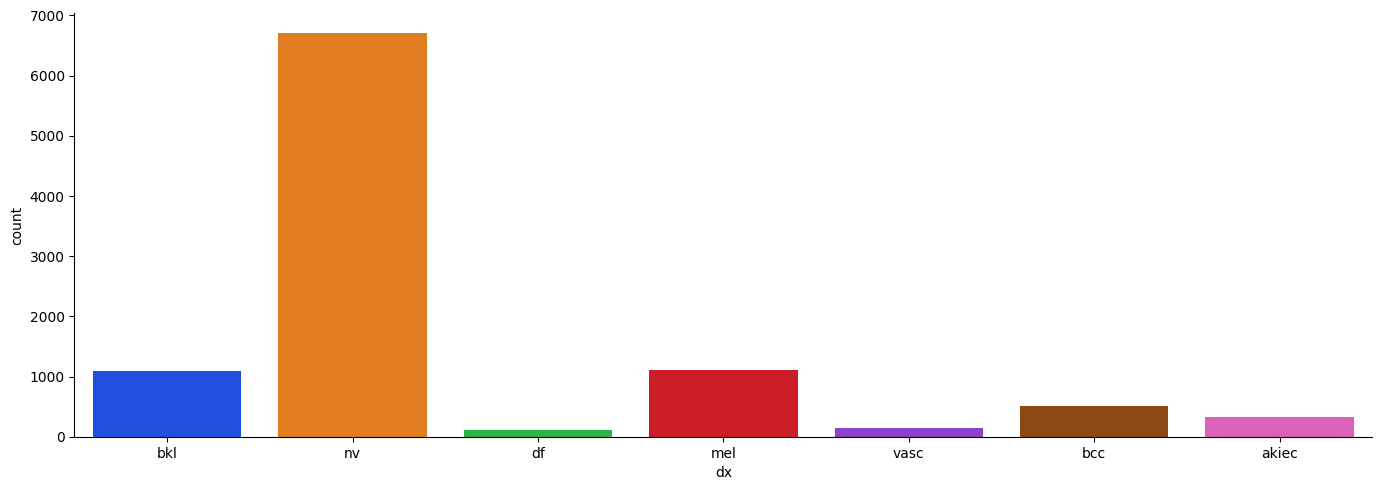

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
...
import seaborn as sns

sns.catplot(x="dx", kind="count", palette="bright", data=meta)
plt.gcf().set_size_inches(16, 5)

In [30]:
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

img_size = 64  # размер изображений
X = []
y = []

for i in tqdm(meta['image_id']):
    img_path1 = f'/content/HAM10000_images_part_1/{i}.jpg'
    img_path2 = f'/content/HAM10000_images_part_2/{i}.jpg'
    img_path = img_path1 if os.path.exists(img_path1) else img_path2
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_size, img_size))
        X.append(img)

        label = meta[meta['image_id'] == i]['dx'].values[0]
        y.append(label)

X = np.array(X)
y = np.array(y)

100%|██████████| 10015/10015 [01:53<00:00, 88.29it/s] 


In [34]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Посмотреть, какие метки чему соответствуют:
print(le.classes_)

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Преобразуем метки в one-hot
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Масштабируем пиксели от 0 до 1
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

# Создаём модель
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,626,055 (6.20 MB)

 Trainable params: 1,626,055 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(X_train_scaled, y_train_cat,
                    epochs=10,
                    validation_data=(X_test_scaled, y_test_cat))

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 211ms/step - accuracy: 0.6499 - loss: 1.1472 - val_accuracy: 0.6665 - val_loss: 0.9133
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 203ms/step - accuracy: 0.6685 - loss: 0.9303 - val_accuracy: 0.6750 - val_loss: 0.8758
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 204ms/step - accuracy: 0.6798 - loss: 0.8628 - val_accuracy: 0.6725 - val_loss: 0.8982
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 83s 208ms/step - accuracy: 0.6963 - loss: 0.8195 - val_accuracy: 0.6955 - val_loss: 0.8078
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 51s 203ms/step - accuracy: 0.7133 - loss: 0.7676 - val_accuracy: 0.7109 - val_loss: 0.7803
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - accuracy: 0.7193 - loss: 0.7449 - val_accuracy: 0.7154 - val_loss: 0.7708
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 193ms/step - accuracy: 0.7335 - loss: 0.7191 - val_accuracy: 0.7024 - val_loss: 0.8101
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 194ms/step - accuracy: 0.7407 - loss: 0

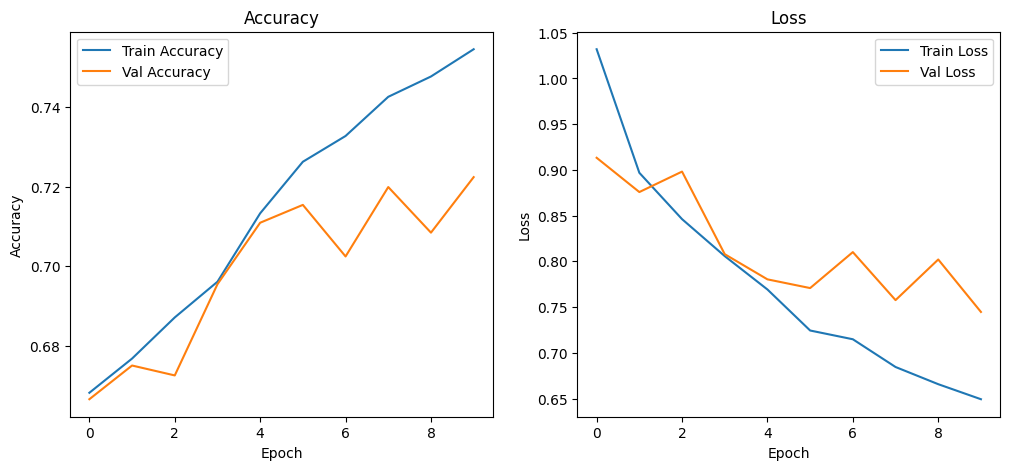

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

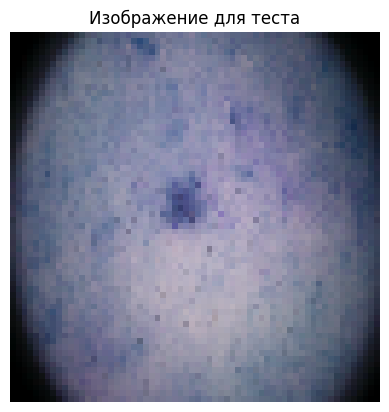

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Предсказанный класс: nv
Настоящий класс:     nv


In [38]:
# Выбираем случайное изображение
import random

idx = random.randint(0, len(X_test_scaled) - 1)
img = X_test_scaled[idx]

# Показываем изображение
plt.imshow(img)
plt.axis('off')
plt.title("Изображение для теста")
plt.show()

# Предсказание
pred = model.predict(np.expand_dims(img, axis=0))
pred_class = np.argmax(pred)

print("Предсказанный класс:", le.classes_[pred_class])
print("Настоящий класс:    ", le.classes_[y_test[idx]])

In [39]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.7 MB/s eta 0:00:00


In [40]:
import gradio as gr
import cv2
import numpy as np

# Твои классы (если ты их кодировала через LabelEncoder)
class_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']  # пример

def predict_skin_disease(img):
    # Предобработка
    img_resized = cv2.resize(img, (64, 64))  # если ты обучала на 64x64
    img_scaled = np.array(img_resized) / 255.0
    img_input = np.expand_dims(img_scaled, axis=0)

    # Предсказание
    prediction = model.predict(img_input)
    class_index = np.argmax(prediction)
    class_name = class_labels[class_index]

    return f"Предсказанный диагноз: {class_name}"

# Gradio интерфейс
interface = gr.Interface(
    fn=predict_skin_disease,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="CancerMe - Skin Cancer Prediction",
    description="Загрузите фото родинки, чтобы получить предсказание от AI"
)

interface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://96caec61d40e5bb9bb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://96caec61d40e5bb9bb.gradio.live
